In [1]:
import datetime
import json
import os
from pathlib import Path
import random
import subprocess
from osgeo import gdal, osr
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import rasterio
from pyproj import Transformer
from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    SentinelHubRequest,
    SHConfig,
    bbox_to_dimensions,
)
from shapely.geometry import Point
from collections import defaultdict

In [2]:
def plot_image(image, factor=1, clip_range=(0, 1)):
    # Apply factor to image
    image = image * factor

    # Clip image values
    image = image.clip(clip_range[0], clip_range[1])

    # Plot the image
    plt.imshow(image)
    plt.show()

In [17]:
# will fetch the lon-lats at center of each county from the file state_county_lon_lats.csv

archive_dir = Path("ML-ARCHIVES--v01/")
scll = archive_dir / "state_county_lon_lat.csv"

df_scll = pd.read_csv(scll).drop(["lon", "lat"], axis=1)
print(df_scll.head())

  state_name county_name
0   COLORADO     LARIMER
1   COLORADO       LOGAN
2   COLORADO      MORGAN
3   COLORADO    SEDGWICK
4   COLORADO        WELD


In [18]:
county_dir = Path("COUNTY-BOUNDING-POLYGONS/")
if not county_dir.exists():
    county_dir.makedirs(exist_ok=True)
county_file = "cb_2022_us_county_20m.dbf"
county_path = county_dir / county_file

# Load county boundary data from Shapefile
counties = gpd.read_file(county_path)

  STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID     NAME        NAMELSAD  \
0      17      127  01784730  0500000US17127  17127   Massac   Massac County   
1      27      017  00659454  0500000US27017  27017  Carlton  Carlton County   
2      37      181  01008591  0500000US37181  37181    Vance    Vance County   
3      47      079  01639755  0500000US47079  47079    Henry    Henry County   
4      06      021  00277275  0500000US06021  06021    Glenn    Glenn County   

  STUSPS      STATE_NAME LSAD       ALAND    AWATER  \
0     IL        Illinois   06   614218330  12784614   
1     MN       Minnesota   06  2230473967  36173451   
2     NC  North Carolina   06   653701481  42190675   
3     TN       Tennessee   06  1455320362  81582236   
4     CA      California   06  3403160299  33693344   

                                            geometry  
0  POLYGON ((-88.92876 37.30285, -88.90507 37.335...  
1  POLYGON ((-93.06133 46.76655, -92.30168 46.764...  
2  POLYGON ((-78.49778 

In [21]:
def create_lon_lat_seqs(df_scll, counties, count):
    df_scll['STATE_NAME'] = df_scll['state_name'].apply(lambda x: x.title())
    df_scll['NAME'] = df_scll['county_name'].apply(lambda x: x.title())
    # df_scll.index.difference(counties.index)
    broken_counties = [('Illinois', 'De Kalb'),
                ('Illinois',      'La Salle'),
                ('Illinois',     'Mcdonough'),
                ('Illinois',       'Mchenry'),
                ('Illinois',        'Mclean'),
                ('Illinois',      'St Clair'),
                ( 'Indiana',       'De Kalb'),
                ( 'Indiana',      'La Porte'),
                ( 'Indiana',      'Lagrange'),
                (    'Iowa',       'O Brien'),
                (  'Kansas',     'Mcpherson'),
                ('Missouri',    'St Charles'),
                ('Missouri',      'St Louis'),
                ('Missouri', 'Ste Genevieve')]
    fixed_counties = [
        ('Illinois',          'DeKalb',   'DeKalb'),
                ('Illinois',      'Salle', ""),
                ('Illinois',     'Mcdonough', ""),
                ('Illinois',       'Mchenry', ""),
                ('Illinois',        'Mclean', ""),
                ('Illinois',      'St. Clair', ""),
                ( 'Indiana',       'DeKalb', ""),
                ( 'Indiana',      'LaPorte', ""),
                ( 'Indiana',      'Lagrange', ""),
                (    'Iowa',       'Brien', ""),
                (  'Kansas',     'Mcpherson', ""),
                ('Missouri',    'St. Charles', ""),
                ('Missouri',      'St. Louis', ""),
                ('Missouri', 'Ste. Genevieve', "")]
    for (br_state, br_county), (state, county, new_county) in zip(broken_counties, fixed_counties):
        
        sery = counties[(counties.STATE_NAME == state) & (counties.NAME.str.contains(county, case=False))][["STATE_NAME", "NAME"]]
        df_scll.loc[(df_scll.STATE_NAME == br_state) & (df_scll.NAME == br_county), ["STATE_NAME", "NAME"]] = [sery["STATE_NAME"].iloc[0], sery["NAME"].iloc[0]]
        if len(sery) == 0:
            print(county, sery)
    df_scll = df_scll.set_index(["STATE_NAME", "NAME"])
    counties = counties.set_index(["STATE_NAME", "NAME"])
    j_counties = counties.join(df_scll, on=["STATE_NAME", "NAME"], how='inner')
    assert len(df_scll.index.difference(counties.index)) == 0
    j_counties["points"] = j_counties.sample_points(size=count)
    samples = j_counties["points"].to_dict()
    seq_lat_lon = defaultdict(lambda: defaultdict(list))
    for (state, county), points in samples.items():
        seq_lat_lon[state][county] =  [ (p.x, p.y) for p in points.geoms ]
    return seq_lat_lon


print(datetime.datetime.now())
seq_lat_lon = create_lon_lat_seqs(df_scll, counties, 5000)
print(datetime.datetime.now())


# <span style=color:blue>Save dict as json  </span>

out_file = archive_dir / "state_county__seq_of_lon_lats.json"

with out_file.open("w") as fp:
    json.dump(seq_lat_lon, fp)



2023-06-05 10:33:47.116680
2023-06-05 10:34:20.799596


In [54]:
rect = j_counties.points.unary_union.envelope

In [61]:
import contextily as cx

In [69]:
rect.bounds

(-105.72008977117176, 36.01259331580543, -80.55956895299119, 43.49583029537451)

In [70]:
j_counties.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

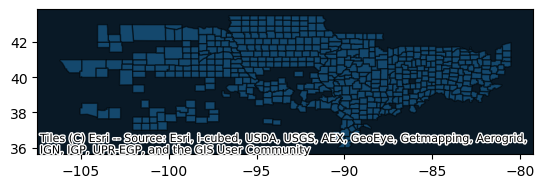

In [71]:
ax = j_counties.plot(alpha=0.5, edgecolor="k")#gpd.GeoDataFrame(geometry=[rect], crs=j_counties.crs).plot(alpha=0.5, edgecolor="k")
cx.add_basemap(ax, zoom=12, source=cx.providers.Esri.WorldImagery)

In [82]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl
import geopandas
import json

countries = gpd.GeoDataFrame(geometry=[j_counties.unary_union], crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
# m.add_layer(gpd.GeoDataFrame(geometry=[j_counties.unary_union.envelope], crs=j_counties.crs))
# m.add_control(LayersControl())

m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

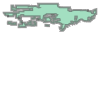

In [92]:
gpd.GeoDataFrame(geometry=[j_counties.unary_union], crs=j_counties.crs)

In [93]:
from shapely.ops import unary_union
boundary = gpd.GeoSeries(unary_union(j_counties.unary_union))

In [95]:
j_counties.unary_union.bounds

(-106.190554078709, 35.995812, -80.518893, 43.500885)

In [103]:
def make_grid(polygon, edge_size):
    """
    polygon : shapely.geometry
    edge_size : length of the grid cell
    """
    from itertools import product
    import numpy as np
    import geopandas as gpd
    
    bounds = polygon.bounds
    x_coords = np.arange(bounds[0] + edge_size/2, bounds[2], edge_size)
    y_coords = np.arange(bounds[1] + edge_size/2, bounds[3], edge_size)
    combinations = np.array(list(product(x_coords, y_coords)))
    squares = gpd.points_from_xy(combinations[:, 0], combinations[:, 1]).buffer(edge_size / 2, cap_style=3)
    return gpd.GeoSeries(squares[squares.intersects(polygon)])


/Users/claudio/.conda/envs/geo/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [152]:
j_counties

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID  \
STATE_NAME NAME                                                        
Illinois   Massac       17      127  01784730  0500000US17127  17127   
           Kendall      17      093  00424248  0500000US17093  17093   
Iowa       Iowa         19      095  00465236  0500000US19095  19095   
Indiana    Greene       18      055  00451676  0500000US18055  18055   
           Miami        18      103  00450373  0500000US18103  18103   
...                    ...      ...       ...             ...    ...   
Iowa       Dubuque      19      061  00465219  0500000US19061  19061   
Ohio       Geauga       39      055  01074040  0500000US39055  39055   
           Clark        39      023  01074024  0500000US39023  39023   
Nebraska   Morrill      31      123  00835883  0500000US31123  31123   
Illinois   Mason        17      125  00424261  0500000US17125  17125   

                          NAMELSAD STUSPS LSAD       ALAND    AWATER  \
STATE_NAME NAME                                                        
Illinois   Massac    Massac County     IL   06   614218330  12784614   
           Kendall  Kendall County     IL   06   829412771   5136525   
Iowa       Iowa        Iowa County     IA   06  1518911690   2686847   
Indiana    Greene    Greene County     IN   06  1404983953   8919619   
           Miami      Miami County     IN   06   968246954   9184623   
...                            ...    ...  ...         ...       ...   
Iowa       Dubuque  Dubuque County     IA   06  1575486019  21140740   
Ohio       Geauga    Geauga County     OH   06  1036793138  20701156   
           Clark      Clark County     OH   06  1025322040  14608569   
Nebraska   Morrill  Morrill County     NE   06  3687911916  15923124   
Illinois   Mason      Mason County     IL   06  1396914848  62748513   

                                                             geometry  \
STATE_NAME NAME                                                         
Illinois   Massac   POLYGON ((-88.92876 37.30285, -88.90507 37.335...   
           Kendall  POLYGON ((-88.60193 41.71956, -88.26195 41.724...   
Iowa       Iowa     POLYGON ((-92.29816 41.86278, -91.83138 41.861...   
Indiana    Greene   POLYGON ((-87.24074 39.17177, -87.05458 39.168...   
           Miami    POLYGON ((-86.16846 40.99610, -85.94644 40.999...   
...                                                               ...   
Iowa       Dubuque  POLYGON ((-91.13277 42.64584, -90.89741 42.645...   
Ohio       Geauga   POLYGON ((-81.39176 41.42427, -81.37481 41.431...   
           Clark    POLYGON ((-84.05101 39.87981, -84.03607 40.040...   
Nebraska   Morrill  POLYGON ((-103.37039 41.69921, -103.36262 41.7...   
Illinois   Mason    POLYGON ((-90.35452 40.12422, -90.20614 40.155...   

                   state_name county_name  \
STATE_NAME NAME                             
Illinois   Massac    ILLINOIS      MASSAC   
           Kendall   ILLINOIS     KENDALL   
Iowa       Iowa          IOWA        IOWA   
Indiana    Greene     INDIANA      GREENE   
           Miami      INDIANA       MIAMI   
...                       ...         ...   
Iowa       Dubuque       IOWA     DUBUQUE   
Ohio       Geauga        OHIO      GEAUGA   
           Clark         OHIO       CLARK   
Nebraska   Morrill   NEBRASKA     MORRILL   
Illinois   Mason     ILLINOIS       MASON   

                                                               points  
STATE_NAME NAME                                                        
Illinois   Massac   MULTIPOINT (-88.89650 37.32825, -88.65594 37.1...  
           Kendall  MULTIPOINT (-88.58836 41.51671, -88.52788 41.6...  
Iowa       Iowa     MULTIPOINT (-92.23628 41.82544, -92.10597 41.6...  
Indiana    Greene   MULTIPOINT (-87.15997 39.06501, -87.09199 39.0...  
           Miami    MULTIPOINT (-86.15673 40.59721, -86.10699 40.6...  
...                                                               ...  
Iowa       Dubuque  MULTIPOINT (-

In [106]:
countries

,geometry
0,"POLYGON ((-105.19055 40.99581, -105.19055 39.9..."
1,"POLYGON ((-105.19055 41.99581, -105.19055 40.9..."
2,"POLYGON ((-104.19055 37.99581, -104.19055 36.9..."
3,"POLYGON ((-104.19055 38.99581, -104.19055 37.9..."
4,"POLYGON ((-104.19055 40.99581, -104.19055 39.9..."
...,...
142,"POLYGON ((-81.19055 40.99581, -81.19055 39.995..."
143,"POLYGON ((-81.19055 41.99581, -81.19055 40.995..."
144,"POLYGON ((-80.19055 39.99581, -80.19055 38.995..."
145,"POLYGON ((-80.19055 40.99581, -80.19055 39.995..."


In [162]:
grid = make_grid(j_counties.points.unary_union, 0.2)
countries = gpd.GeoDataFrame(geometry=grid, crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=(52.3,8.0), zoom = 3, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
m

Map(center=[52.3, 8.0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_…

In [37]:

#!/usr/bin/env python
# coding: utf-8

# ## <span style=color:blue>This notebook builds the function soy_is_here(year,lat,lon), which produces "True" if the 100m x 100m area around lon-lat was a soybean field in the given year.  (At least, according to the data of USDA NASS.)  </span>
#
# ## <span style=color:blue>Then we import the dictionary with the lon-lat sequences for each county, and for each year find the first 20 that are in soybean fields, and right

# <span style=color:blue>First step is to create a function that tests, given a year-lon-lat triple, whether there was a soy field at lat-lon during the given year.  This is based on checking files downloaded from https://www.nass.usda.gov/Research_and_Science/Cropland/Release/index.php.  To understand the meaning of the pixel values, please see https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/meta.php and the files in there, e.g., https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia22.htm.  Among other things, you will see that the value of '5' corresponds to soybean fields </span>

# first, examining the structure of the files I downloaded

dir_main = Path("CROPSCAPE/DATA-DOWNLOADS/")
dir_main.mkdir(parents=True, exist_ok=True)


# following the structure of the directory name and file from downloaded zip files, which are organized by year
def pathname_for_year(year):
    last_dir_name = f"{str(year)}_30m_cdls/"
    file_name = f"{str(year)}_30m_cdls.tif"
    return dir_main / last_dir_name / file_name

def dataset_for_year(year):
    dataset = rasterio.open(str(pathname_for_year(year)))
    return dataset

# test
print(pathname_for_year(2022))
# <span style=color:blue>Now we inspect structure of the tif files.     </span>
#
# #### <span style=color:blue>Note that the Coordinate Reference System (CRS) is EPSG: 5070 rather than EPSG:4326 (also basically equivalent to WGS84), which is the one we are often using.  BTW, the unit of measure for EPSG:5070 is 1 meter, and so the pixels in these tif files are approximately 30m x 30m.  (See https://epsg.io/5070-1252) </span>


def pull_useful_gdal(dataset):
    useful = {}

    # Get raster band count
    useful["band_count"] = dataset.RasterCount

    # Get size
    useful["size"] = [dataset.RasterXSize, dataset.RasterYSize]

    # Get corner coordinates
    geotransform = dataset.GetGeoTransform()
    useful["proj:transform"] = geotransform
    x_size = dataset.RasterXSize
    y_size = dataset.RasterYSize

    corners = {
        "upperLeft": [geotransform[0], geotransform[3]],
        "lowerLeft": [geotransform[0], geotransform[3] + geotransform[5] * y_size],
        "upperRight": [geotransform[0] + geotransform[1] * x_size, geotransform[3]],
        "lowerRight": [
            geotransform[0] + geotransform[1] * x_size,
            geotransform[3] + geotransform[5] * y_size,
        ],
    }

    # Compute center coordinates
    corners["center"] = [
        (corners["upperLeft"][0] + corners["lowerRight"][0]) / 2,
        (corners["upperLeft"][1] + corners["lowerRight"][1]) / 2,
    ]
    useful["cornerCoordinates"] = corners

    # Define the source and target spatial references
    src_srs = osr.SpatialReference()
    src_srs.ImportFromWkt(dataset.GetProjection())
    print("Dataset project", dataset.GetProjection())

    tgt_srs = osr.SpatialReference()
    tgt_srs.ImportFromEPSG(4326)  # 4326  # WGS84 #  , 8826

    # Set up a coordinate transformation
    transform = osr.CoordinateTransformation(src_srs, tgt_srs)

    # Get corner coordinates and reproject them
    corners_projected = {}
    for name, coords in [
        ("upperLeft", (0, 0)),
        ("lowerLeft", (0, dataset.RasterYSize)),
        ("upperRight", (dataset.RasterXSize, 0)),
        ("lowerRight", (dataset.RasterXSize, dataset.RasterYSize)),
    ]:
        x, y = gdal.ApplyGeoTransform(geotransform, *coords)
        lon, lat, _ = transform.TransformPoint(x, y)
        corners_projected[name] = [lon, lat]
    useful["cornerCoordinatesProj"] = corners_projected

    # Get bounding box
    # bbox = {
    #     'west_longitude': min(corners_projected['upperLeft'][0], corners_projected['lowerLeft'][0], corners_projected['upperRight'][0], corners_projected['lowerRight'][0]),
    #     'north_latitude': max(corners_projected['upperLeft'][1], corners_projected['lowerLeft'][1], corners_projected['upperRight'][1], corners_projected['lowerRight'][1]),
    #     'east_longitude': max(corners_projected['upperLeft'][0], corners_projected['lowerLeft'][0], corners_projected['upperRight'][0], corners_projected['lowerRight'][0]),
    #     'south_latitude': min(corners_projected['upperLeft'][1], corners_projected['lowerLeft'][1], corners_projected['upperRight'][1], corners_projected['lowerRight'][1])
    # }
    bbox = {
        "west_longitude": corners_projected["upperLeft"][0],
        "north_latitude": corners_projected["upperLeft"][1],
        "east_longitude": corners_projected["lowerRight"][0],
        "south_latitude": corners_projected["lowerRight"][1],
    }
    useful["bbox"] = bbox
    bbox = {
        "west_longitude": corners["upperLeft"][0],
        "north_latitude": corners["upperLeft"][1],
        "east_longitude": corners["lowerRight"][0],
        "south_latitude": corners["lowerRight"][1],
    }
    useful["bbox_noproj"] = bbox

    # Get EPSG code
    useful["espgEncoding"] = int(src_srs.GetAuthorityCode(None))

    return useful


def pull_useful(
    ginfo,
):  # should give as input the result.stdout from calling gdalinfo -json
    useful = {}
    useful["band_count"] = len(ginfo["bands"])
    useful["cornerCoordinates"] = ginfo["cornerCoordinates"]
    useful["proj:transform"] = ginfo["stac"]["proj:transform"]
    useful["size"] = ginfo["size"]
    useful["bbox"] = ginfo["stac"]["proj:projjson"]["bbox"]
    useful["espgEncoding"] = ginfo["stac"]["proj:epsg"]
    return useful


path_to_file = pathname_for_year(2008)
# path_to_file = pathname_for_year(2022)
dataset = gdal.Open(str(path_to_file))
useful_gdal = pull_useful_gdal(dataset)
gdalInfoReq = " ".join(["gdalinfo", "-json", str(path_to_file)])

result = subprocess.run([gdalInfoReq], shell=True, capture_output=True, text=True)

print()


print(result.stderr)
gdalInfo = json.loads(result.stdout)

useful = pull_useful(gdalInfo)
with open("gdal_process.json", "w") as outfile:
    json.dump(useful, outfile, indent=2, sort_keys=True)
with open("gdal_lib.json", "w") as outfile:
    json.dump(useful_gdal, outfile, indent=2, sort_keys=True)
# exit()


# <span style=color:blue>Function to transform from EPSG:4326 to EPSG:5070.  The rasterio-based function we use below will take coordinates in EPSG:5010, since the tif files we are using here are in EPSG:5010.     </span>

transformer = Transformer.from_crs("EPSG:4326", "EPSG:5070")


def from_4326_to_5070(lon, lat):
    # I'm not sure why the role positions of lon-lat are different on input and output
    # but that is what my numerous small test runs showed to me
    new_lon, new_lat = transformer.transform(lat, lon)
    return new_lon, new_lat


# test on coordinates from central Iowa
old_lon = -92.8
old_lat = 42.7
print(from_4326_to_5070(old_lon, old_lat))
# (you can check this at https://epsg.io/transform)
# <span style=color:blue>Function that fetches a 3x3 square of pixel values from the given tif file.  The pixels in the tif file correspond to  30m x 30m, so we are looking at a rouhgly 100m x 100m area that is all or mostly soybean field </span>
#
# <span style=color:blue>Note that in 2008 the target area was planted mainly with maize, but in 2022 it was planted with soybeans</span>


# expects lon-lat to be in EPSG:4326.
# These are converted to EPSG:5070 inside the function
def get_coordinate_pixels(dataset, lon, lat):
    lon_new, lat_new = from_4326_to_5070(lon, lat)

    py, px = dataset.index(lon_new, lat_new)

    # create 3px x 3px window centered on the lon-lat
    window = rasterio.windows.Window(px - 1, py - 1, 3, 3)
    clip = dataset.read(window=window)
    return clip


# test
# old_lon = -92.8
# old_lat = 42.7
# path_to_file = pathname_for_year(2008)
# print(get_coordinate_pixels(path_to_file, old_lon, old_lat))
# print()
# path_to_file = pathname_for_year(2022)
# print(get_coordinate_pixels(path_to_file, old_lon, old_lat))
# <span style=color:blue>Also, a function that that tests whether all 9 spots in the 3x3 square have a given value.  (We are interested in "5", which is soy beans.)</span>


# land_use_val should be an integer; see, e.g.,
#     https://www.nass.usda.gov/Research_and_Science/Cropland/metadata/metadata_ia22.htm
#     for mapping from values to meanings
def usage_is_here(dataset, lon, lat, land_use_val):
    arr = get_coordinate_pixels(dataset, lon, lat)
    out = True
    for i in range(0, 3):
        for j in range(0, 3):
            out = out & (arr[0][i][j] == land_use_val)
    return out


def soy_is_here(dataset, lon, lat):
    return usage_is_here(dataset, lon, lat, 5) # 1 is corn, 5 is soy

def corn_is_here(dataset, lon, lat):
    return usage_is_here(dataset, lon, lat, 1) # 1 is corn, 5 is soy

# old_lon = -92.8
# old_lat = 42.7
# print(corn_is_here(2008, old_lon, old_lat))
# print(corn_is_here(2022, old_lon, old_lat))
# ### <span style=color:blue>Importing the dictionary with lon-lat sequences.  Also setting a second dict that will hold lists lon-lats that are in soybean fields.</span>

# <span style=color:blue>Function that scans through one list of lon-lats and finds first set that are in soybean fields</span>


def gen_corn_lon_lats(dataset, year, state, county, count):
    points = seq_lat_lon[state][county]
    i = 0
    out_list = []
    for ll in points:
        if corn_is_here(dataset, ll[0], ll[1]):
            out_list += [ll]
            i += 1
        if i == 20:
            return out_list, []
    print(
        f"\nFor {str(year)}, {state}, {county}: \nFailed to find {str(count)} lon-lats that were in corn fields. Found only {str(i)}.\n"
    )
    short_fall_record = [year, state, county, i]
    return out_list, short_fall_record


corn_lat_lons, short = gen_corn_lon_lats(dataset_for_year(2008), 2008, "ILLINOIS", "MASSAC", 20)
print(corn_lat_lons)
print(short)
print()
# list, short = gen_soy_lon_lats(2008, "MISSOURI", "DALLAS", 20)
# print(list)
# print(short)
# <span style=color:blue>Function that generates a fixed number of lon-lats in soybean fields for each year and each county. This took quite a while to run completely -- about 4 hours.    </span>

working_dir = Path("OUTPUTS/OUTPUT-v01/")
working_dir.mkdir(parents=True, exist_ok=True)
dict1_file = working_dir / "year_state_county_corn_seq.json"
short_list = working_dir / "year_state_county_shortfalls.json"


def gen_all_corn_lists(corn_lat_lons, count):
    dict1 = {}
    for year in range(2008, 2023):
        dict1[year] = {}
        for key in corn_lat_lons.keys():
            dict1[year][key] = {}
    print(dict1.keys())
    print(dict1[2013].keys())

    shortfall_list = []

    i = 0
    for year in dict1.keys():
        dataset = dataset_for_year(year)
        for state in corn_lat_lons.keys():
            for county in corn_lat_lons[state].keys():
                points, short = gen_corn_lon_lats(dataset, year, state, county, count)
                dict1[year][state][county] = points
                if short != []:
                    shortfall_list += [short]

                i += 1
                if i % 20 == 0:
                    print(
                        f"Have generated corn lon-lat lists for {str(i)} year-county pairs"
                    )
                if i % 50 == 0:
                    with dict1_file.open("w") as fp:
                        json.dump(dict1, fp)
                    with short_list.open("w") as fp:
                        json.dump(shortfall_list, fp)

    return dict1, shortfall_list


print(datetime.datetime.now())
dict1, short = gen_all_corn_lists(seq_lat_lon, 20)
print(datetime.datetime.now())
# <span style=color:blue>Save the dict1 and also the shortfalls    </span>

dict1_file = archive_dir / "year_state_county_corn_seq.json"
short_list = archive_dir / "year_state_county_shortfalls.json"

with dict1_file.open("w") as fp:
    json.dump(dict1, fp)
with short_list.open("w") as fp:
    json.dump(short, fp)
# <span style=color:blue>Collecting year-state-county with zero hits </span>

zero_falls = []

for l in short:
    if l[3] == 0:
        zero_falls += [[l]]

print(len(zero_falls))

print(json.dumps(zero_falls, indent=4))

zero_file = archive_dir / "year_state_county_corn_zero_falls.json"
with zero_file.open("w") as fp:
    json.dump(zero_falls, fp)
# <span style=color:blue>Checking if any year-state-county in zero_falls had a positive yield in year_state_county_yield table</span>

yscy_file = archive_dir / "year_state_county_yield.csv"

df_yscy = pd.read_csv(yscy_file)
print("Top of df_yscy")
print(df_yscy.head())

zero_with_yield = []
for l in zero_falls:
    year = l[0][0]
    state = l[0][1]
    county = l[0][2]
    rows = df_yscy[
        (df_yscy["year"] == year)
        & (df_yscy["state_name"] == state)
        & (df_yscy["county_name"] == county)
    ]
    if len(rows) > 0:
        y = rows["yield"].iloc[0]
        zero_with_yield += [
            {"year": year, "state_name": state, "county_name": county, "yield": y}
        ]

print("\nLength of zero_with_yield is: ", len(zero_with_yield))
print("\nListing of zero_with_yield")
df_zwy = pd.DataFrame(zero_with_yield)
print(df_zwy.head(30))

zero_with_yield = archive_dir / "year_state_county_soy_zero_with_yield.csv"
df_zwy.to_csv(zero_with_yield, index=False)
# <span style=color:blue>For this exercise, we will drop these year-state-county triples from consideration.  A more thorough approach would be to focus on these year-state-county pairs (and perhaps the other ones with < 20 lon-lats), and randomly generate more lon-lats within the county until at least a few are found inside soybean fields.  (On the one hand, there have to be some if there was a yield ... however, CropScape is not perfect and may not have identified them accurately.)</span>


CROPSCAPE/DATA-DOWNLOADS/2022_30m_cdls/2022_30m_cdls.tif
Dataset project PROJCS["NAD83 / Conus Albers",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",23],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",29.5],PARAMETER["standard_parallel_2",45.5],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","5070"]]


(260567.23440705295, 2193569.0320861563)

For 2008, ILLINOIS, MASSAC: 
Failed to find 20 lon-lats that were in corn fields. Found only 0.

[]
[2008, 'ILLINOIS', 'MASSAC', 0]

2023-06-05 11:09:44.771054
dict_keys([2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 201

In [40]:
%env SENTINEL_CLIENT_ID=0d67f2dd-b15f-4a0d-a504-143db1f4b0f7
%env SENTINEL_CLIENT_SECRET=!{nz6Re26F{>uQ2RP;h/eDuR|V%;7]hGB27.xa#W

env: SENTINEL_CLIENT_ID=0d67f2dd-b15f-4a0d-a504-143db1f4b0f7
env: SENTINEL_CLIENT_SECRET=!{nz6Re26F{>uQ2RP;h/eDuR|V%;7]hGB27.xa#W


In [ ]:

#!/usr/bin/env python
# coding: utf-8

# ## <span style=color:blue>In this notebook, we illustrate how to get the NDVI value for a single cell of size roughly 100m x 100m.  This will give you the basic machinery needed to gather sequences of NDVI values that can be incorporated into your ML pipelines   </span>

# ### <span style=color:blue>First, we create function that retrieves the NVDI for a given year, week, and 100m x 100m cell centered at some lon-lat   </span>

# <span style=color:blue>To get started with accessing SentinelHub using Python, I found the site https://sentinelhub-py.readthedocs.io/en/latest/index.html to be helpful.  In particular, you can find and download the SentinelHub-py github repository at https://github.com/sentinel-hub/sentinelhub-py, and then work through some of the Examples.</span>
#
# <span style=color:blue>First, we set up access to SentinelHub</span>

# To access SentinelHub you need a client_id and client_secret.
# To get your own access to SentinelHub, go
#    to https://docs.sentinel-hub.com/api/latest/api/overview/authentication/.
#    From there you can get a user name and password for a free 30-day trial.
#    Once you sign in, find you way to
#    https://apps.sentinel-hub.com/dashboard/, and from the
#    "User Settings" area you can create an OAuth client -- this will give you
#    a Client_ID and a Client_Secret.  (I had to create a couple of these in order
#    to get one that worked.  Also, they do expire after a while...)
# I put my client_ID and client_secret into some environment variables

SENTINEL_CLIENT_ID = os.getenv("SENTINEL_CLIENT_ID")
SENTINEL_CLIENT_SECRET = os.environ.get("SENTINEL_CLIENT_SECRET")
# <span style=color:blue>Now create a client for accessing SentinelHub     </span>

config = SHConfig()

# using third client id and secret, from 2023-05-26
config.sh_client_id = SENTINEL_CLIENT_ID
config.sh_client_secret = SENTINEL_CLIENT_SECRET

if not config.sh_client_id or not config.sh_client_secret:
    print(
        "Warning! To use Process API, please provide the credentials (OAuth client ID and client secret)."
    )
else:
    print("Successfully set up SentinelHub client")
# <span style=color:blue> Not sure why sentinelhub examples include this next cell, but I will blindly imitate them   </span>


# <span style=color:blue>Importing useful things from SentinelHub  </span>

# The following is not a package. It is a file utils.py which should be in the same
#     folder as this notebook.
# As a slight variation, I have cloned the sentinelhub-py repo into my local github,
#     and grab utils.py from there
# ### <span style=color:blue>As a small warm-up exercise, to help you get familiar with accessing data from SentinalHub, here is an example of pulling some RGB data and viewing it     </span>
#
# <span style=color:blue> First, identifying a couple of bounding boxes to work with. Note that the second example is focusing on a single cell with size about 100m x 100m. </span>

# convenient site for finding lat/long coordinates:
#     http://bboxfinder.com/#0.000000,0.000000,0.000000,0.000000

# Bounding box containing the 7 soybean states of interest is as follows:
# [-104.370117,35.782171,-79.628906,48.048710]
# However, this is too big of a region to request in one call to SentinelHub

# Bounding box for about 1/8 of Iowa
# [-96.481934,42.520700,-95.075684,43.516689]


In [161]:
j_counties.set_geometry("points")

STATEFP COUNTYFP  COUNTYNS        AFFGEOID  GEOID  \
STATE_NAME NAME                                                        
Illinois   Massac       17      127  01784730  0500000US17127  17127   
           Kendall      17      093  00424248  0500000US17093  17093   
Iowa       Iowa         19      095  00465236  0500000US19095  19095   
Indiana    Greene       18      055  00451676  0500000US18055  18055   
           Miami        18      103  00450373  0500000US18103  18103   
...                    ...      ...       ...             ...    ...   
Iowa       Dubuque      19      061  00465219  0500000US19061  19061   
Ohio       Geauga       39      055  01074040  0500000US39055  39055   
           Clark        39      023  01074024  0500000US39023  39023   
Nebraska   Morrill      31      123  00835883  0500000US31123  31123   
Illinois   Mason        17      125  00424261  0500000US17125  17125   

                          NAMELSAD STUSPS LSAD       ALAND    AWATER  \
STATE_NAME NAME                                                        
Illinois   Massac    Massac County     IL   06   614218330  12784614   
           Kendall  Kendall County     IL   06   829412771   5136525   
Iowa       Iowa        Iowa County     IA   06  1518911690   2686847   
Indiana    Greene    Greene County     IN   06  1404983953   8919619   
           Miami      Miami County     IN   06   968246954   9184623   
...                            ...    ...  ...         ...       ...   
Iowa       Dubuque  Dubuque County     IA   06  1575486019  21140740   
Ohio       Geauga    Geauga County     OH   06  1036793138  20701156   
           Clark      Clark County     OH   06  1025322040  14608569   
Nebraska   Morrill  Morrill County     NE   06  3687911916  15923124   
Illinois   Mason      Mason County     IL   06  1396914848  62748513   

                                                             geometry  \
STATE_NAME NAME                                                         
Illinois   Massac   POLYGON ((-88.92876 37.30285, -88.90507 37.335...   
           Kendall  POLYGON ((-88.60193 41.71956, -88.26195 41.724...   
Iowa       Iowa     POLYGON ((-92.29816 41.86278, -91.83138 41.861...   
Indiana    Greene   POLYGON ((-87.24074 39.17177, -87.05458 39.168...   
           Miami    POLYGON ((-86.16846 40.99610, -85.94644 40.999...   
...                                                               ...   
Iowa       Dubuque  POLYGON ((-91.13277 42.64584, -90.89741 42.645...   
Ohio       Geauga   POLYGON ((-81.39176 41.42427, -81.37481 41.431...   
           Clark    POLYGON ((-84.05101 39.87981, -84.03607 40.040...   
Nebraska   Morrill  POLYGON ((-103.37039 41.69921, -103.36262 41.7...   
Illinois   Mason    POLYGON ((-90.35452 40.12422, -90.20614 40.155...   

                   state_name county_name  \
STATE_NAME NAME                             
Illinois   Massac    ILLINOIS      MASSAC   
           Kendall   ILLINOIS     KENDALL   
Iowa       Iowa          IOWA        IOWA   
Indiana    Greene     INDIANA      GREENE   
           Miami      INDIANA       MIAMI   
...                       ...         ...   
Iowa       Dubuque       IOWA     DUBUQUE   
Ohio       Geauga        OHIO      GEAUGA   
           Clark         OHIO       CLARK   
Nebraska   Morrill   NEBRASKA     MORRILL   
Illinois   Mason     ILLINOIS       MASON   

                                                               points  
STATE_NAME NAME                                                        
Illinois   Massac   MULTIPOINT (-88.89650 37.32825, -88.65594 37.1...  
           Kendall  MULTIPOINT (-88.58836 41.51671, -88.52788 41.6...  
Iowa       Iowa     MULTIPOINT (-92.23628 41.82544, -92.10597 41.6...  
Indiana    Greene   MULTIPOINT (-87.15997 39.06501, -87.09199 39.0...  
           Miami    MULTIPOINT (-86.15673 40.59721, -86.10699 40.6...  
...                                                               ...  
Iowa       Dubuque  MULTIPOINT (-

In [154]:
big_grid = make_grid(j_counties.points.unary_union, 3.3)
big_counties_grid = gpd.GeoDataFrame(geometry=big_grid, crs=j_counties.crs)
big_grid_geo_wgs84 = big_counties_grid.to_crs("wgs84").geometry#[0].bounds

small_grid = make_grid(j_counties.points.unary_union, 2.2)
small_counties_grid = gpd.GeoDataFrame(geometry=small_grid, crs=j_counties.crs)
small_grid_geo_wgs84 = small_counties_grid.to_crs("wgs84").geometry#[0].bounds

In [163]:
for i, geo in enumerate(small_grid.geometry):
    resolution2 = 100 # make grid ~2.2
    point_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    point_iowa_size = bbox_to_dimensions(point_iowa_bbox, resolution=resolution2)
    print(
        f"For grid cell {i}, image shape at {resolution2} m resolution: {point_iowa_size} pixels"
    )

for i, geo in enumerate(big_grid.geometry):
    resolution1 = 150 # make grid ~3.3
    corner_iowa_bbox = BBox(bbox=geo.bounds, crs=CRS.WGS84)
    corner_iowa_size = bbox_to_dimensions(corner_iowa_bbox, resolution=resolution1)
    print(
        f"For grid cell {i}, image shape at {resolution1} m resolution: {corner_iowa_size} pixels"
    )

For grid cell 0, image shape at 100 m resolution: (1944, 2449) pixels
For grid cell 1, image shape at 100 m resolution: (1886, 2450) pixels
For grid cell 2, image shape at 100 m resolution: (1825, 2451) pixels
For grid cell 3, image shape at 100 m resolution: (1888, 2495) pixels
For grid cell 4, image shape at 100 m resolution: (1827, 2496) pixels
For grid cell 5, image shape at 100 m resolution: (1763, 2498) pixels
For grid cell 6, image shape at 100 m resolution: (1986, 2416) pixels
For grid cell 7, image shape at 100 m resolution: (1929, 2416) pixels
For grid cell 8, image shape at 100 m resolution: (1870, 2417) pixels
For grid cell 9, image shape at 100 m resolution: (1929, 2461) pixels
For grid cell 10, image shape at 100 m resolution: (1870, 2462) pixels
For grid cell 11, image shape at 100 m resolution: (1808, 2463) pixels
For grid cell 12, image shape at 100 m resolution: (1973, 2383) pixels
For grid cell 13, image shape at 100 m resolution: (1916, 2383) pixels
For grid cell 14

In [186]:
j_counties.total_bounds

array([-106.19055408,   35.995812  ,  -80.518893  ,   43.500885  ])

In [196]:
from ipyleaflet import Map, WMSLayer
# from sentinelhub.data_request import WmsRequest, WcsRequest
# from sentinelhub.constants import MimeType, CustomUrlParam
# from sentinelhub.common import BBox, CRS

grid = make_grid(j_counties.points.unary_union, 0.2)
countries = gpd.GeoDataFrame(geometry=grid, crs=j_counties.crs)#.plot(alpha=0.5, edgecolor="k")

m = Map(center=[40.198611, -92.575278], zoom = 6, basemap= basemaps.Esri.WorldTopoMap)

geo_data = GeoData(geo_dataframe = countries,
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.05, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.6},
                   hover_style={'fillColor': 'red' , 'fillOpacity': 0.2},
                   name = 'Countries')

m.add_layer(geo_data)
sh_wms_url = 'https://services.sentinel-hub.com/ogc/wms/08f41ee9-4eae-4191-9683-24bbb69f8119?showlogo=0&time=2017-07-18/2017-07-30'

m.add_layer(WMSLayer(url=sh_wms_url, layers="TRUE-COLOR-S2-L1C", tile_size=512, opacity=0.5))
m

Map(center=[40.198611, -92.575278], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title'…

In [168]:
corner_iowa_color_imgs_1_day

[array([[[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [50, 42, 40],
         [48, 42, 39],
         [49, 43, 40]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [49, 42, 40],
         [50, 43, 40],
         [53, 45, 41]],
 
        [[ 0,  0,  0],
         [ 0,  0,  0],
         [ 0,  0,  0],
         ...,
         [58, 49, 44],
         [57, 48, 43],
         [53, 45, 42]],
 
        ...,
 
        [[55, 44, 41],
         [55, 44, 41],
         [53, 43, 40],
         ...,
         [45, 38, 37],
         [46, 38, 37],
         [45, 38, 38]],
 
        [[55, 44, 40],
         [45, 39, 37],
         [57, 44, 41],
         ...,
         [43, 36, 37],
         [44, 38, 38],
         [42, 36, 36]],
 
        [[53, 42, 40],
         [48, 41, 39],
         [39, 36, 36],
         ...,
         [40, 36, 36],
         [44, 38, 38],
         [42, 36, 37]]], dtype=uint8)]

In [ ]:

# <span style=color:blue>Getting RGB for corner_iowa_bbox     </span>
#
# <span style=color:blue>Here is some helpful text from the example notebook "process_request.ipynb" that I have been following for this part of my notebook </span>
#
# We build the request according to the API Reference, using the SentinelHubRequest class. Each Process API request also needs an evalscript.
#
# The information that we specify in the SentinelHubRequest object is:
#
#     an evalscript,
#     a list of input data collections with time interval,
#     a format of the response,
#     a bounding box and it's size (size or resolution).
#
# The evalscript in the example is used to select the appropriate bands. We return the RGB (B04, B03, B02) Sentinel-2 L1C bands.
#
# With request_true_color_1_day, the image from Jun 12th 2020 is downloaded. Without any additional parameters in the evalscript, the downloaded data will correspond to reflectance values in UINT8 format (values in 0-255 range).
#
# <span style=color:blue>I am also experimenting with request_true_color_7_day, to see what happens if my interval is multiple days. </span>

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color_1_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-13"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

request_true_color_7_day = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-19"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)
# <span style=color:blue>Invoking these two functions    </span>

corner_iowa_color_imgs_1_day = request_true_color_1_day.get_data()
corner_iowa_color_imgs_7_day = request_true_color_7_day.get_data()
# <span style=color:blue>Exploring the outputs.  It appears that the multi-day gives back the sums of the values for the days that are contributing.    </span>

print(
    f"Returned data is of type = {type(corner_iowa_color_imgs_1_day)} and length {len(corner_iowa_color_imgs_1_day)}."
)
print(
    f"Single element in the list is of type {type(corner_iowa_color_imgs_1_day[-1])} and has shape {corner_iowa_color_imgs_1_day[-1].shape}"
)
print()
print(corner_iowa_color_imgs_1_day)


print(
    f"Returned data is of type = {type(corner_iowa_color_imgs_7_day)} and length {len(corner_iowa_color_imgs_7_day)}."
)
print(
    f"Single element in the list is of type {type(corner_iowa_color_imgs_7_day[-1])} and has shape {corner_iowa_color_imgs_7_day[-1].shape}"
)
print()
print(corner_iowa_color_imgs_7_day)
# <span style=color:blue>To plot first single-day image, we have to  get the values to be between 0 and 1.  In fact, we first scale to (0,1) but then multiply by 3.5 to brighten the picture    </span>

ci_image_1_day = corner_iowa_color_imgs_1_day[0]
print(f"Type of each value in ci_image_1_day: {ci_image_1_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_1_day, factor=3.5 / 255, clip_range=(0, 1))
# <span style=color:blue>Let's look at how the 7-day interval turns out...   </span>

ci_image_7_day = corner_iowa_color_imgs_7_day[0]
print(f"Type of each value in ci_image_7_day: {ci_image_7_day.dtype}")

# plot function
# factor 1/255 to scale between 0-1
# factor 3.5 to increase brightness
plot_image(ci_image_7_day, factor=1 / 255, clip_range=(0, 1))
# ### <span style=color:blue>Oh my - the clouds are dominating the top part of image!! Please see the example of building cloud masks in the file process_request.ipynb in the Examples area of the sentinelhub-py github repo.    </span>

# <span style=color:blue>Building a sentinel request to pull NDVI values for a single 100m x 100m cell.  Recall the formula for NDVI is (B08 - B04) / (B08 + B04).</span>

# Recall that we built point_iowa_bbox (along with point_iowa_size)
# to be a single pixel of size 100m x 100m, that was in a soybean field in 2022

# It is centered at
# lon = -94.7386486
# lat = 42.6846289  

evalscript_NVDI_bands = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B04", "B08"]
            }],
            output: {
                bands: 2
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B08];
    }
"""

request_NVDI_corner = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2020-06-12", "2020-06-14"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=corner_iowa_bbox,
    size=corner_iowa_size,
    config=config,
)

request_NVDI_point = SentinelHubRequest(
    evalscript=evalscript_NVDI_bands,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2022-08-02", "2022-08-03"),
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.PNG)],
    bbox=point_iowa_bbox,
    size=point_iowa_size,
    config=config,
)

print(request_NVDI_point)
data = request_NVDI_point.get_data()
print(data)
print()
B04 = data[0][0][0][0]
B08 = data[0][0][0][1]
print(B04, B08)
NVDI = (B08 - B04) / (B08 + B04)
print("\nNVDI is: ", NVDI)

print()


# ### <span style=color:blue>Note: if you run the above request on point_iowa_box for "2022-08-01" to "2022-08-02", then you get [0,0].  I think this is because the satellite didn't go over this cell on that one day. Remember that with the two sentinel-2 satellites taken together there is a 5-day return rate. In general, one should probably make single-cell requests that are across a 5 day span, e.g., 2022-04-01 to 2022-04-06. </span>